# ML for BioImaging - Coding Convolutional Neural Networks in Pytorch

Practical work originally created by Alasdair Newson (https://sites.google.com/site/alasdairnewson/)

For any remark or suggestion, please feel free to contact me at:

- loic.lefolgoc@telecom-paris.fr

### Objective:

We want to implement a Convolutional Neural Network (CNN) for image recognition. For this we will use two well-known datasets, the first simpler and the second more complicated :

- MNIST (images of digits)
- CIFAR-10 dataset https://www.cs.toronto.edu/~kriz/cifar.html.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

<br>We will first code the simple ConvNet described below using the Pytorch environment : https://pytorch.org/.

- The input of the CNN is a set of (3,m,n) image tensors (m and n depend on the dataset).
- We apply
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same' (i.e. we apply zero-padding)
    - additive biases
    - a ReLu activation function
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same' (i.e. we apply zero-padding)
    - additive biases
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)
    - We then Flatten the data (reduce them to a vector in order to be able to apply a Fully-Connected layer to it)
    - A softmax activation function which outputs are the $P(y_c | X)$ (multi-class problem)


<IMG SRC='https://drive.google.com/uc?export=view&id=10xVi1LejX5TAI-tuOQM-UrSrNYa9gi0q'>
    
You should use the "SAME" border conditions.
    
### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE)

# Load packages

In [27]:
pip install torchvision inline

In [28]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

### CNN model in Pytorch

There are several ways to write a CNN model in pytorch. In this lab, you will be using the _Sequential_ class of pytorch (similarly to Tensorflow). We will see the syntax further on.



# Import data

We first import the MNIST dataset. The training set is imported in `mnist_trainset` and the test set in `mnist_testset`.

In practice, training on `mnist_trainset` takes too much time for this practical work. For this reason, we define a smaller training set (`mnist_trainset_reduced`) with a random subset of images. We will use `mnist_trainset_reduced` when training.

In [29]:
# Convert input to Pytorch tensors (ToTensor includes a rescaling from the range [0,255] to [0.0,1.0])
input_transform=transforms.Compose([transforms.ToTensor()])

# Download MNIST training data
mnist_trainset = datasets.MNIST(root='./data',train=True,download=True,transform=input_transform)
print(mnist_trainset)

# Download test dataset
mnist_testset = datasets.MNIST(root='./data',train=False,download=True,transform=input_transform)

# Create data loader with smaller dataset size
max_mnist_size = 2000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0]

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


We also make a direct access to the training and test data as `torch` tensors. We will use them for visualization purposes and to compute the final training/test accuracies.

In [30]:
# Extract the actual data and labels
X_train = torch.unsqueeze(mnist_trainset.data,axis=1)[mnist_trainset_reduced.indices]/255.0
Y_train = mnist_trainset.targets[mnist_trainset_reduced.indices]
X_test = torch.unsqueeze(mnist_testset.data,axis=1)/255.0
Y_test = mnist_testset.targets

## Exploring the data

We can explore the dataset `mnist_trainset` manually, although when we train the model, we will use the ```DataLoader``` of Pytorch (see later).

The images are contained in a sub-structure of ```mnist_trainset``` called ```data```. The labels are contained in another sub-structure of ```mnist_trainset``` called ```targets```. Note that these are kept in their native format (the transformations are not applied to them), so to use them we have to apply the transformation manually, as above.

__NOTE__ In general, if you want to find out what a structure contains, use the command ```dir()```, this will give you a list of the sub-structures.

__NOTE__ `mnist_trainset_reduced` is a `Subset` object rather than a `Dataset` object. We cannot call `.data` and `.target` directly on it, although we can pass it as argument to a `DataLoader`.

In [31]:
print(dir(mnist_trainset))

print("Size of training data : ", mnist_trainset.data.shape)
print("Size of training labels : ", mnist_trainset.targets.shape)


['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_check_exists', '_check_legacy_exist', '_format_transform_repr', '_load_data', '_load_legacy_data', '_repr_indent', 'class_to_idx', 'classes', 'data', 'download', 'extra_repr', 'mirrors', 'processed_folder', 'raw_folder', 'resources', 'root', 'target_transform', 'targets', 'test_data', 'test_file', 'test_labels', 'train', 'train_data', 'train_labels', 'training_file', 'transform', 'transforms']
Size of training data :  torch.Size([60000, 28, 28])
Size of training labels :  torch.Size([60000])


The mnist dataset has 10 classes. These are the following :

In [32]:
mnist_list = [ '0', '1','2','3','4','5','6','7','8','9']

## Display some of the images

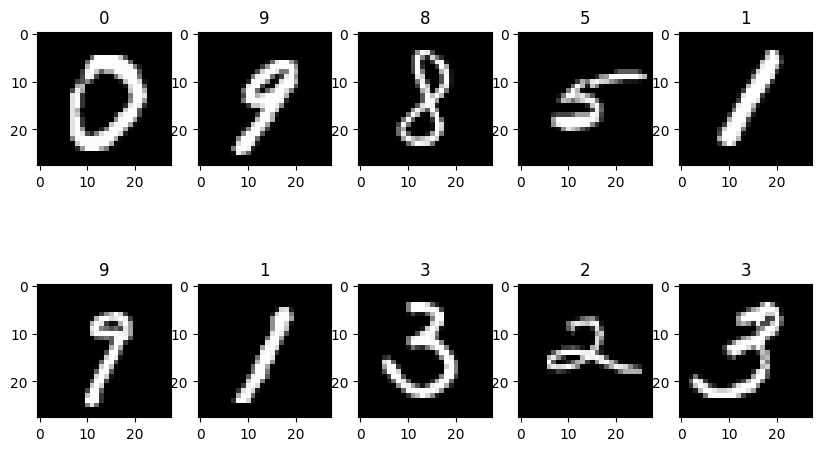

In [33]:
plt.figure(figsize=(10, 6))
for idx in range(0,10):
    plt.subplot(2, 5, idx+1)
    rand_ind = np.random.randint(0,mnist_trainset.data.shape[0])
    plt.imshow(mnist_trainset.data[rand_ind,:,:],cmap='gray')
    plt.title(mnist_list[int(mnist_trainset.targets[rand_ind])])

# Defining the model for MNIST

We will now define the simple CNN described above, for use with MNIST. The input of the CNN is a set of (28,28,1) image tensors. We apply the following layers:

    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
    - a ReLu activation function
    
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)
    
    - We then Flatten the data: reduce them to a vector in order to be able to apply a Fully-Connected layer to it
    - Dense (fully connected) layer. Note, you will have to determine the input size, that is to say the number of elements after the last Max Pooling layer.

__VERY IMPORTANT NOTE !!!__

Pytorch carries out the softmax which we would expect at the end of our network automatically in the loss function that we will use, so there is no need to add it. Nevertheless, you must understand that the network output is a vector (of logits) which is _not_ normalised to be a probability distribution. This will be important later on.

Now, we define the following hyper-parameters of the model :

In [34]:
learning_rate = 0.01
n_epochs = 10
batch_size = 64
nb_classes = int(mnist_trainset.targets.max()+1)

nb_filters = 32       # number of convolutional filters to use
kernel_size = (3, 3)  # convolution kernel size
pool_size = (2, 2)    # size of pooling area for max pooling

# --- Size of the successive layers
n_h_0 = 1             # greyscale input images
n_h_1 = nb_filters
n_h_2 = nb_filters

# Model 1 : defining a CNN with the Sequential API of Pytorch for MNIST

We are now going to create the CNN with Pytorch.

The Sequential approach is quite similar to that of Tensorflow. To define a model, just write:

```my_model = torch.nn.Sequential( first_layer, second_layer, ...)```

Each layer must be a function imported from the Pytorch. You can use the following functions:

- ```torch.nn.Conv2d()```
- ```torch.nn.ReLU()```
- ```torch.nn.MaxPool2d()```
- ```torch.nn.Flatten()```
- ```torch.nn.Linear()```

Look at the documentation online to find the correct parameters. For example:

- https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html


In [35]:
# BEGIN STUDENT CODE
mnist_model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=32*14*14, out_features=nb_classes)
)

# END STUDENT CODE

In [36]:
dummy = torch.zeros(1, 1, 28, 28)
print(mnist_model[:-1](dummy).shape)

torch.Size([1, 6272])


## Define dataloader

We use the ```torch.utils.data.DataLoader``` function of Pytorch to easily iterate over mini-batches of data. ```torch.utils.data.DataLoader``` is a useful function to extract batches of data from a dataset, applying the transformations which we have specified (conversion to Pytorch tensor, normalisation etc).

We will train using the smaller training set, `mnist_trainset_reduced`.

In [37]:
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset_reduced, batch_size=batch_size, shuffle=True)

## Define loss function and optimiser

Pytorch provides an easy way to define the loss criterion to optimise. The syntax is (considering that the Adam optimiser is used):

- ```criterion = torch.nn.BCELoss()``` or ```criterion = torch.nn.CrossEntropyLoss()```, etc., depending on your problem.
- ```optimizer = torch.optim.Adam(mnist_model.parameters(), lr=learning_rate)```

Fill in the following code, choosing the correct criterion to optimise. For the criterion, the individual loss over individual data samples can be aggregated into the total loss in several ways. Choose `reduction='sum'`, which takes the sum of individual losses.

In [38]:
# BEGIN STUDENT CODE
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_model.parameters(), lr=learning_rate)
# END STUDENT CODE

## CNN prediction conversion

We recall here that the output of the classification CNN in Pytorch is a vector which is __NOT__ normalised to be a probability distribution. Therefore, for the purposes of finding the prediction of the CNN, we create a function which first converts an input vector to a probability distribution, and then determines the most likely class for each vector. The output should be, for each vector, an integer between 0 and (number of classes) $-1$.

The inputs to this function will be Pytorch tensors, so you can use the following Pytorch functions on them :

- ```torch.nn.Softmax()```
- ```torch.argmax()```

Create this function now.

In [39]:
def vector_to_class(x):
  # BEGIN STUDENT CODE
  y = torch.argmax(torch.nn.Softmax(dim=1)(x), dim=1)
  # END STUDENT CODE
  return y

## Accuracy

Now, define a function which calculates the accuracy of the output of the neural network, with respect to the input labels. We consider that the input is a vector of class numbers (similar to the output of `vector_to_class`, but converted to a numpy array).

In [40]:
def cnn_accuracy(predict,labels):
  # BEGIN STUDENT CODE
  accuracy = (predict == labels).mean()
  # END STUDENT CODE
  return accuracy

## Training the model

Now, we carry out the actual training of the model.

In [41]:
train_losses=[]
valid_losses=[]

for epoch in range(0,n_epochs):
  train_loss=0.0
  all_labels = []
  all_predicted = []

  for batch_idx, (imgs, labels) in enumerate(mnist_train_loader):
    # pass the samples through the network
    predict = mnist_model(imgs) # FILL IN STUDENT
    # apply loss function
    loss = criterion(predict,labels) # FILL IN STUDENT
    # set the gradients back to 0
    optimizer.zero_grad() # FILL IN STUDENT
    # backpropagation
    loss.backward() # FILL IN STUDENT
    # parameter update
    optimizer.step() # FILL IN STUDENT
    # compute the train loss
    train_loss += loss.item()
    # store labels and class predictions
    all_labels.extend(labels.tolist())
    all_predicted.extend(vector_to_class(predict).tolist())

  print('Epoch:{} Train Loss:{:.4f}'.format(epoch,train_loss/len(mnist_train_loader.dataset)))

  # calculate accuracy
  print('Accuracy:{:.4f}'.format(cnn_accuracy(np.array(all_predicted),np.array(all_labels))))

Epoch:0 Train Loss:0.0310
Accuracy:0.5865
Epoch:1 Train Loss:0.0041
Accuracy:0.9280
Epoch:2 Train Loss:0.0022
Accuracy:0.9625
Epoch:3 Train Loss:0.0013
Accuracy:0.9790
Epoch:4 Train Loss:0.0007
Accuracy:0.9900
Epoch:5 Train Loss:0.0005
Accuracy:0.9965
Epoch:6 Train Loss:0.0002
Accuracy:0.9990
Epoch:7 Train Loss:0.0001
Accuracy:0.9995
Epoch:8 Train Loss:0.0001
Accuracy:1.0000
Epoch:9 Train Loss:0.0001
Accuracy:1.0000


<br> Let's compute the final training and test accuracies:

In [42]:
# Calculate accuracy on the training set and the test set

# BEGIN FILL IN STUDENT (use X_train, Y_train, X_test, Y_test)
predict_train = mnist_model(X_train)
predict_test = mnist_model(X_test)
predict_tr = vector_to_class(predict_train).numpy()
predict_te = vector_to_class(predict_test).numpy()

train_accuracy = cnn_accuracy(predict_tr, Y_train.numpy())
test_accuracy = cnn_accuracy(predict_te, Y_test.numpy())
# END FILL IN STUDENT

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 1.0
Test Accuracy: 0.9481


Visual results : 


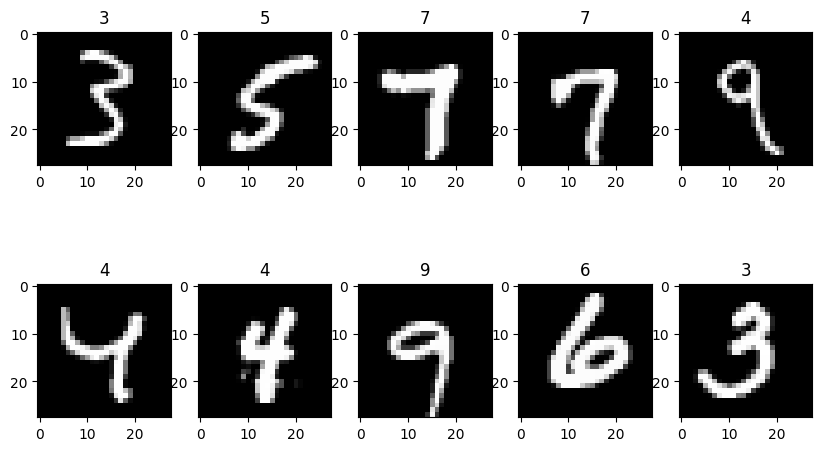

In [43]:
print("Visual results : ")

plt.figure(figsize=(10, 6))
for idx in range(0,10):
    plt.subplot(2, 5, idx+1)
    rand_ind = np.random.randint(0,X_test.shape[0])
    test_img = torch.unsqueeze(X_test[rand_ind,:,:,:],axis=1)
    predicted_class = vector_to_class(mnist_model(test_img))
    plt.imshow(test_img.squeeze(),cmap='gray')
    plt.title(mnist_list[int(predicted_class)])

# Model 2: create a CNN on CIFAR10

We are now going to train the same network architecture on a more difficult dataset : CIFAR-10

First, we import the CIFAR-10 data and carry out some pre-processing :

In [62]:
# Data augmentation for training (helps reduce overfitting)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),           # Randomly flip images
    transforms.RandomCrop(32, padding=4),        # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color variations
    transforms.ToTensor(),
])

# No augmentation for test data (just convert to tensor)
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download CIFAR-10 training data WITH augmentation
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
print(cifar_trainset)

# Download test dataset WITHOUT augmentation
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Create data loader with more training data
max_cifar_size = 50000  # Increased from 5000 to 10000
cifar_trainset_reduced = torch.utils.data.random_split(cifar_trainset, [max_cifar_size, len(cifar_trainset)-max_cifar_size])[0]


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomCrop(size=(32, 32), padding=4)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=None)
               ToTensor()
           )


In [63]:
# Extract the actual data and labels
X_train = torch.from_numpy(cifar_trainset.data[cifar_trainset_reduced.indices]/255.0).float().permute(0,3,1,2).to(device)
Y_train = torch.tensor(cifar_trainset.targets, dtype=torch.uint8)[cifar_trainset_reduced.indices].to(device)
X_test = torch.from_numpy(cifar_testset.data/255.0).float().permute(0,3,1,2).to(device)
Y_test = torch.tensor(cifar_testset.targets, dtype=torch.uint8).to(device)

nb_channels = X_train.shape[1]

In [64]:
# The CIFAR10 categories
cifar_10_list = [ 'airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']

## Display some of the images

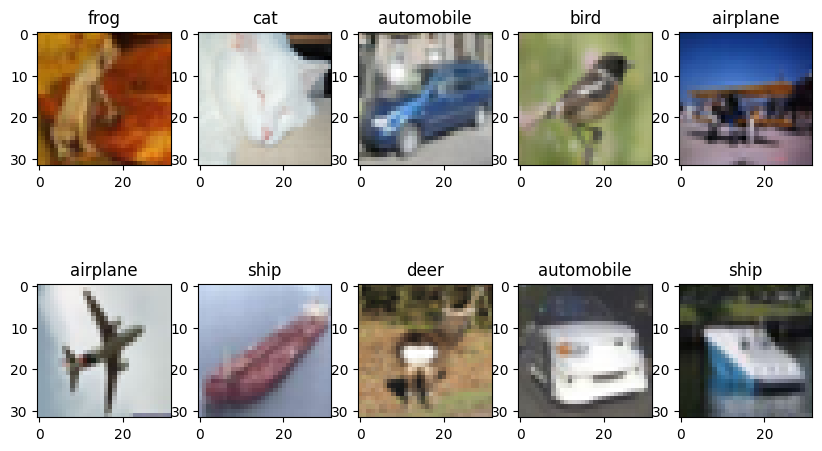

In [65]:
plt.figure(figsize=(10, 6))
for idx in range(0,10):
    plt.subplot(2, 5, idx+1)
    rand_ind = np.random.randint(0,X_test.shape[0])
    # Move the tensor to CPU and convert to numpy before plotting
    plt.imshow(X_test[rand_ind,:,:,:].permute(1,2,0).cpu().numpy())
    plt.title(cifar_10_list[int(Y_test[rand_ind])])

# Define the architecture again, for CIFAR-10

In this case, we are going to add a layer because the data is more complex. Therefore, we use the following architecture :

    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
    - additive biases
    - a ReLu activation function
    
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
    - additive biases
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)
    
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
    - additive biases
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)

    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
    - additive biases
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)
    
    - We then Flatten the data (reduce them to a vector in order to be able to apply a Fully-Connected layer to it)
    - Dense (fully connected) layer

In [66]:
n_epochs = 25
batch_size = 256
nb_classes = 10

nb_filters = 32         # number of convolutional filters to use
kernel_size = (3, 3)    # convolution kernel size
pool_size = (2, 2)      # size of pooling area for max pooling

# --- Size of the successive layers
n_h_0 = nb_channels
n_h_1 = nb_filters
n_h_2 = nb_filters
n_h_3 = nb_filters

Now, modify the previous code (you can copy/paste/modify the necessary parts) to define the model for CIFAR-10.

In [67]:
# BEGIN STUDENT CODE
# Improved architecture with batch normalization and dropout
cifar_model = torch.nn.Sequential(
    # Block 1: Two conv layers + pooling
    torch.nn.Conv2d(3, 32, kernel_size=3, padding=1),
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(),
    torch.nn.Conv2d(32, 32, kernel_size=3, padding=1),
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),  # 32x32 -> 16x16
    torch.nn.Dropout(0.2),

    # Block 2: Two conv layers + pooling
    torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64, 64, kernel_size=3, padding=1),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),  # 16x16 -> 8x8
    torch.nn.Dropout(0.3),

    # Block 3: Two conv layers + pooling
    torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
    torch.nn.BatchNorm2d(128),
    torch.nn.ReLU(),
    torch.nn.Conv2d(128, 128, kernel_size=3, padding=1),
    torch.nn.BatchNorm2d(128),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),  # 8x8 -> 4x4
    torch.nn.Dropout(0.4),

    # Fully connected layers
    torch.nn.Flatten(),
    torch.nn.Linear(128 * 4 * 4, 256),  # Larger FC layer
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, 10),
    # REMOVED Softmax - CrossEntropyLoss includes it!
)

cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset_reduced, batch_size=batch_size, shuffle=True)
criterion = torch.nn.CrossEntropyLoss()
# Lower learning rate for better convergence
optimizer = torch.optim.Adam(cifar_model.parameters(), lr=0.001, weight_decay=1e-4)

# After creating optimizer, add:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)


cifar_model.to(device)


# END STUDENT CODE


Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2, inplace=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Dropout(p=0.3, inplace=False)
  (16): Conv2d(64, 128, kernel_size=(3, 3), strid

Now, carry out training on the CIFAR-10 dataset (use the previous code as an example).

In [68]:
# BEGIN STUDENT CODE
train_losses=[]
valid_losses=[]

for epoch in range(0,n_epochs):
  train_loss=0.0
  all_labels = []
  all_predicted = []

  for batch_idx, (imgs, labels) in enumerate(cifar_train_loader):
    # Move data to GPU
    imgs, labels = imgs.to(device), labels.to(device)

    # pass the samples through the network
    predict = cifar_model(imgs) # FILL IN STUDENT
    # apply loss function
    loss = criterion(predict,labels) # FILL IN STUDENT
    # set the gradients back to 0
    optimizer.zero_grad() # FILL IN STUDENT
    # backpropagation
    loss.backward() # FILL IN STUDENT
    torch.nn.utils.clip_grad_norm_(cifar_model.parameters(), max_norm=1.0)
    # parameter update
    optimizer.step() # FILL IN STUDENT
    # compute the train loss
    train_loss += loss.item()
    # store labels and class predictions
    all_labels.extend(labels.tolist())
    all_predicted.extend(vector_to_class(predict).tolist())

  print('Epoch:{} Train Loss:{:.4f}'.format(epoch,train_loss/len(cifar_train_loader.dataset)))

  # calculate accuracy
  print('Accuracy:{:.4f}'.format(cnn_accuracy(np.array(all_predicted),np.array(all_labels))))
  # In your training loop, after each epoch:
  scheduler.step(train_loss)
# END STUDENT CODE

Epoch:0 Train Loss:0.0068
Accuracy:0.3504
Epoch:1 Train Loss:0.0054
Accuracy:0.5011
Epoch:2 Train Loss:0.0047
Accuracy:0.5729
Epoch:3 Train Loss:0.0043
Accuracy:0.6125
Epoch:4 Train Loss:0.0040
Accuracy:0.6438
Epoch:5 Train Loss:0.0038
Accuracy:0.6671
Epoch:6 Train Loss:0.0036
Accuracy:0.6854
Epoch:7 Train Loss:0.0034
Accuracy:0.7000
Epoch:8 Train Loss:0.0033
Accuracy:0.7133
Epoch:9 Train Loss:0.0032
Accuracy:0.7243
Epoch:10 Train Loss:0.0031
Accuracy:0.7342
Epoch:11 Train Loss:0.0030
Accuracy:0.7439
Epoch:12 Train Loss:0.0029
Accuracy:0.7524
Epoch:13 Train Loss:0.0028
Accuracy:0.7623
Epoch:14 Train Loss:0.0027
Accuracy:0.7681
Epoch:15 Train Loss:0.0026
Accuracy:0.7755
Epoch:16 Train Loss:0.0026
Accuracy:0.7818
Epoch:17 Train Loss:0.0025
Accuracy:0.7856
Epoch:18 Train Loss:0.0025
Accuracy:0.7891
Epoch:19 Train Loss:0.0024
Accuracy:0.7982
Epoch:20 Train Loss:0.0024
Accuracy:0.7985
Epoch:21 Train Loss:0.0023
Accuracy:0.8053
Epoch:22 Train Loss:0.0023
Accuracy:0.8087
Epoch:23 Train Loss:0

Print the training and test accuracy (use the previous code as an example):

In [77]:
import torch

# Define the path where you want to save the model
model_save_path = 'cifar_model.pth'

# Save only the model's state_dict
torch.save(cifar_model.state_dict(), model_save_path)

print(f"Model state dictionary saved to {model_save_path}")

Model state dictionary saved to cifar_model.pth


To load the model back, you would first define the model architecture (as you did with `cifar_model`), and then load the state dictionary:

```python
# First, re-instantiate your model architecture (e.g., cifar_model = torch.nn.Sequential(...))
# cifar_model = torch.nn.Sequential(...)

# Then, load the state dictionary
cifar_model.load_state_dict(torch.load('cifar_model.pth'))

# Set the model to evaluation mode if you're only performing inference
cifar_model.eval()

print("Model loaded successfully!")
```

In [71]:
# Calculate accuracy on the training set and the test set

# BEGIN FILL IN STUDENT (use X_train, Y_train, X_test, Y_test)
cifar_model.eval() # Set model to evaluation mode
with torch.no_grad(): # Disable gradient calculation for inference
  # Create TensorDatasets and DataLoaders for X_train and X_test
  train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
  test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
  train_loader_accuracy = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
  test_loader_accuracy = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  all_train_predicted = []
  for imgs, _ in train_loader_accuracy:
      imgs = imgs.to(device)
      predict = cifar_model(imgs)
      all_train_predicted.extend(vector_to_class(predict).tolist())
  predict_tr = np.array(all_train_predicted)

  all_test_predicted = []
  for imgs, _ in test_loader_accuracy:
      imgs = imgs.to(device)
      predict = cifar_model(imgs)
      all_test_predicted.extend(vector_to_class(predict).tolist())
  predict_te = np.array(all_test_predicted)

train_accuracy = cnn_accuracy(predict_tr, Y_train.cpu().numpy())
test_accuracy = cnn_accuracy(predict_te, Y_test.cpu().numpy())
# END FILL IN STUDENT

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
cifar_model.train() # Set model back to training mode

Train Accuracy: 0.86626
Test Accuracy: 0.838


Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2, inplace=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Dropout(p=0.3, inplace=False)
  (16): Conv2d(64, 128, kernel_size=(3, 3), strid

In [73]:
from sklearn.metrics import f1_score

# Calculate F1 score for the test set
f1 = f1_score(Y_test.cpu().numpy(), predict_te, average='weighted')
print("F1 Score (weighted) on Test Set:", f1)

F1 Score (weighted) on Test Set: 0.836014596421443


 What do you think about the results (better or worse than MNIST) ? Why do you think this is ? How could you improve the results ?
---

The results are worse from a metrics point of view. This might be beacause the CIFAR10 dataset is more complex. We can improve the model by creating more convolutional layers, increasing the sample, adding batch normalization and dropout for regularization, and adding a learning rate scheduler.